# MCMC: A Beginnner's Guide

In this tutorial, I'll be going over the basics of MCMC and running an MCMC on some data. I'm not going to spend much time on the complicated bayesian math that goes into it, but for more detail you can check out http://dan.iel.fm/emcee/current/user/line/ 

For the purposes of this tutorial, we will simply use MCMC (through the Emcee python package), and discuss qualitatively what an MCMC does. 

## So what is MCMC?

MCMC stands for Markov-Chain Monte Carlo, and is a method for fitting models to data. This is a little different from a simple linear least squared or chi-squared fit we might perform to some data. MCMC takes a model, which you develop and could have many input parameters.

MCMC is a parameter space exploration tool. In an extremely general way, what it's doing is setting up a ball of what are known as "walkers" on a grid (parameter space) that contains every model (every combination of possible model parameters) you specify. Each walker generates a model based on the combination of parameters at its current positition, tests it against the data, and establishes a number (known as lnP or ln probability) that is a metric for how "good" the fit is (usually weighted by the uncertainty in the data being used). It then moves one step (step is user defined) to a new place in the parameter space and does the calculation again. If the lnP goes up, it stays, and tries a new location. If it goes down, it goes back to its previous spot and picks a new direction to try. If the lnP is the same, it rolls a dice.

In this way, several hundred walkers explore the parameter space set up by your model, and start honing in on the combination of parameters that seem to produce good fits (these are known as the posteriors). After the MCMC finishes running, you can plot these posteriors over your data to see the fit. 

Of course, in reality things are quite abit more complicated than this, but it's a convenient way to think about the problem. An example is perhaps the best way of illustrating this. 

## Fitting the Earth's Milankovich Cycles 

Located in this directory is a file containing the temperature change, age, deuterium content, etc., of the Earth's atmosphere over the last several million years, calculated from measurements of ice-core samples. For the purposes of this tutorial, we will be interested in only the age and temperature columns. 
The file is called 'ice_core_data.txt', and the ages and $\Delta T$ are in the third and fifth columns, respectively. Load the data and plot the Temperature deviation (from average) against age to see what we will be trying to fit in this tutorial.

In [97]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
%matplotlib inline
plt.rcParams['figure.figsize'] = (20,10)

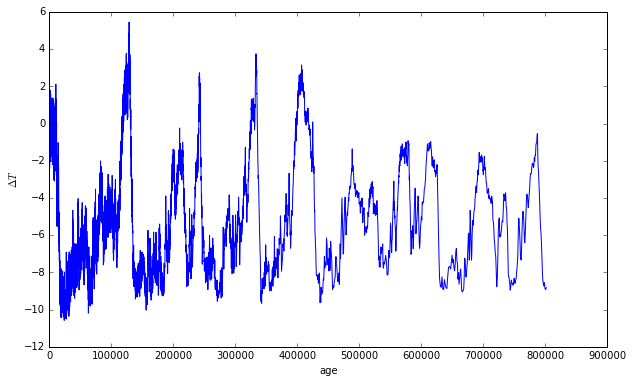

In [17]:
ice_data = np.loadtxt('ice_core_data.txt')
ice_data = np.transpose(ice_data)
age = ice_data[2]
T = ice_data[4]
plt.plot(age,T)
plt.xlabel('age')
plt.ylabel(r'$\Delta T$')
plt.show()


Great. Now, we can see that the temperature of Earth fluctuates a lot over its history, but that those fluctuations seem fairly periodic. It turns out, these fluctuations are due to combinations of small, but important periodic changes in the Earth's tilt (obliquity), rotational precession, orbital precession, eccentricity, and ecliptic inclination. Three of these effects were studied extensively by Milutin Milankovich and have come to be named after him. While not the only effects, they are three of the primary ones driving the fluctuations we see above. 

Those three effects are the obliquity, rotational precession, and eccentricity. For more on these effects, you can check out the wikipedia article: https://en.wikipedia.org/wiki/Milankovitch_cycles 

From the article, we can see that the periods of the Milankovich cycles are approximately 26,000 years, 41,000 years, and 100,000 years. While our model will actually end up fitting our periods for us, but having these numbers in mind will allow us to shorten our MCMC run by introducing good $priors$, which are a priori limitations on the allowed parameter values. For example, if you are simulating galaxy spectra, the age of the galaxy as a free parameter should not be allowed to be greater than the age of the universe. Why let the MCMC spend the time fitting models that are unphysical anyway? 

We can create a basic model for describing the above fluctuations as a sum of three sinusoids, which have different amplitudes and periods corresponding to roughly the Milankovich cycles. This won't work perfectly, but will be good enough for our purposes. Our model will be of the form 
$$
\Delta T = a_1 \sin\left(\frac{2\pi t}{p_1}\right) + a_2 \sin\left(\frac{2\pi t}{p_2}\right) + a_3 \sin\left(\frac{2\pi t}{p_3}\right) + T_0
$$
where $a_1, a_2, a_3, p_1, p_2, p_3,$ and $T_0$ are the parameters we will be fitting for.

## Setting up the MCMC

First, of course, you need an mcmc code- I will be using emcee, which can be installed using pip install emcee. 

We will be creating four functions for this MCMC run. The first is straightforward, and is known as the model. The model function should take as an argument a list (known by convention as theta) of parameters, and return the model evaluated at those parameters. For completion, your model function should also have your age array as an input, which here we can set to default to the age array defined above. Create your function below:

In [18]:
def model(theta,age=age):
    a1,a2,a3,p1,p2,p3,T0 = theta
    return a1*np.sin(2*np.pi*age/p1) + a2*np.sin(2*np.pi*age/p2) + a3*np.sin(2*np.pi*age/p3) + T0

We now need a function referred to as lnlike(). This function takes as an argument theta as well as the $x$, $y$, and $y_{err}$ of your actual theta. It's job is to return a number corresponding to how good a fit your model is to your data for a given set of parameters, weighted by the error in your data points (i.e. it is more important the fit be close to data points with small error bars than points with large error bars). We will use the following formulation to determine this number- translate it to a function in python below:

$$
L_{lnlike} = -\frac{1}{2} \sum{\left(\frac{y-y_{model}}{y_{err}}\right)^{2}}
$$

In [19]:
def lnlike(theta, x, y, yerr):
    return -0.5 * np.sum(((y - model(theta, x))/yerr) ** 2)

The next function we need is one to check, before running the probability function (last one defined) on any set of parameters, that all variables are within their priors (in fact, this is where we set our priors). 

The output of this function is totally arbitrary (it is just encoding True False), but emcee asks that if all priors are satisfied, 0.0 is returned, otherwise return -np.inf. Its input is theta.

Set up an lnprior function that specifies bounds on $a_1,a_2,a_3,p_1,p_2,p_3$ and $T_0$. Reasonable bounds on the amplitudes can be drawn from the plot above (the amplitudes individually can't be greater than the overall amplitude of the final fluctuations, and $T_0$ must be within the upper and lower bounds of the data we see). Priors on the periods are tricker, I suggest going for around ten thousand years around the known Milankovich cycle periods given above- we expect the values to be close to these. (We will talk a bit later about evaluating from "walker plots" whether our priors might not have been great). 

In [20]:
def lnprior(theta):
    a1, a2, a3, p1, p2, p3, T0 = theta
    if 0.0 < a1 < 5.0 and 0.0 < a2 < 5.0 and 0.0 < a3 < 5.0 and 10000. < p1 < 200000 and 10000. < p2 < 200000 and 10000. < p3 < 200000 and -10.0 < T0 < 0:
        return 0.0
    return -np.inf

The last function we need to define is lnprob(). This function combines the steps above by running the lnprior function, and if the function returned -np.inf, passing that through as a return, and if not (if all priors are good), returning the lnlike for that model (by convention we say it's the lnprior output + lnlike output, since lnprior's output should be zero if the priors are good). lnprob needs to take as arguments theta, x, y, and $y_{err}$, since these get passed through to lnlike. 



In [21]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

We have one or two steps left before we can run. First, our Temperature measurements, unfortunately, have no errors provided. But we need errors for the MCMC to run, so let's set a yerr array arbitrarily to 5% of the average temperature in our temperature array. 

We will want to feed our data (x,y,yerr) in as a tuple, so set data equal to a tuple of our age, temperature and temperature error arrays. 

We also need to set a value for nwalkers, which determines how many walkers are initialized in our MCMC. Let's use 500.

We need a variable called initial, which is an initial set of guesses (this will be the first theta, where the MCMC starts). 

Finally we need p0, which is the methodology of stepping from one place to a grid to the next ( I will provide this). 

In [22]:
Terr = 0.05*np.mean(T)
data = (age, T,Terr)
nwalkers = 500
initial = np.array([1.0, 1.0, 1.0, 26000., 41000.,100000.,-4.5])
ndim = len(initial)
p0 = [np.array(initial) + 1e-8 * np.random.randn(ndim) for i in xrange(nwalkers)]

We are now ready to run the MCMC. I'll provide the code for this, since it just amounts to looking up emcee's documentation. 

In [27]:
def main(p0):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 500)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, 1000)

    return sampler

The sampler here contains all the outputs of the MCMC, including the walker chains and the posteriors. We will talk a little bit later about evaluating whether an MCMC has "converged," but for now let's quickly extract a random sampling of our posteriors and plot them over our data.

In [38]:
def plotter(sampler,age=age,T=T):
    plt.ion()
    plt.plot(age,T,label='Change in T')
    samples = sampler.flatchain
    for theta in samples[np.random.randint(len(samples), size=100)]:
        plt.plot(age, model(theta, age), color="r", alpha=0.01)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('Years ago')
    plt.ylabel(r'$\Delta$ T (degrees)')
    plt.legend()
    plt.show()

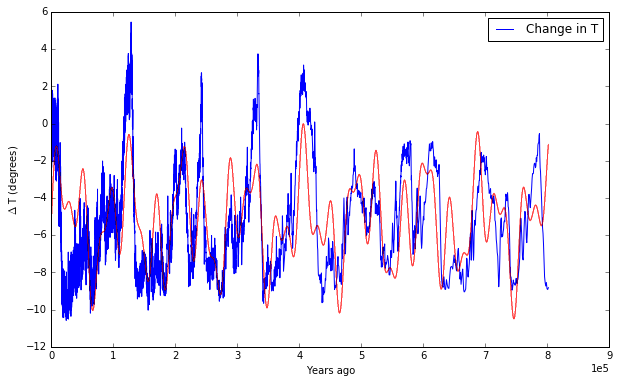

In [39]:
#sampler= main(p0)
plotter(sampler)

We can see from our plot that our simplistic model (of three sinusoids) is not perfect, but it does a pretty good job of matching our data. We can see that from the hundred samples we drew from the posteriors, they all seem to overlap over each other pretty well. We can see the exact values of our parameters as well: 


In [43]:
samples = sampler.flatchain
average_theta = np.ones(7)
for theta in samples[np.random.randint(len(samples), size=100)]:
    average_theta += theta
average_theta /= 100
print average_theta

[  1.33722911e+00   2.08972384e+00   1.90590528e+00   2.35213783e+04
   3.97330215e+04   9.61323799e+04  -5.24603708e+00]


So we find that our amplitudes are 1.3, 2.08, and 1.9 (seems about right, they should be less than around 5), we get periods of 23,521 years, 39,733 years, and 96,132 years (pretty close to our predictions of 26,000, 41,000, and 100,000 years), and a $T_0$ of -5.24 degrees, which we almost could've read straight off the graph in the first place. My simple check above just takes the averages of the posteriors, which is hardly bayesian, but we can also look at, for example, the standard deviation (spread) in posteriors. 

In [86]:
a1 = np.array([])
a2 = np.array([])
a3 = np.array([])
p1 = np.array([])
p2 = np.array([])
p3 = np.array([])
T0 = np.array([])

for theta in samples[np.random.randint(len(samples), size=100)]:
    a1 = np.append(a1,theta[0])
    a2 = np.append(a2,theta[1])
    a3 = np.append(a3,theta[2])
    p1 = np.append(p1,theta[3])
    p2 = np.append(p2,theta[4])
    p3 = np.append(p3,theta[5])
    T0 = np.append(T0,theta[6])


In [87]:
print 'SD a1: ', np.std(a1,ddof=1)
print 'SD a2: ', np.std(a2,ddof=1)
print 'SD a3: ', np.std(a3,ddof=1)
print 'SD p1: ', np.std(p1,ddof=1)
print 'SD p2: ', np.std(p2,ddof=1)
print 'SD p3: ', np.std(p3,ddof=1)
print 'SD T0: ', np.std(T0,ddof=1)

SD a1:  0.00414450255739
SD a2:  0.00475878184913
SD a3:  0.00451232194119
SD p1:  1.44696709644
SD p2:  2.53841538168
SD p3:  11.1269137683
SD T0:  0.00306305316173


This kind of shows us why our posteriors all overlapped when we plotted; the standard deviations in the amplitudes are all smaller than a single tick on the y axis and a ~few thousand year spread in periods doesn't shift things if the shift is spread is around something like 30 to 90 thousand. 

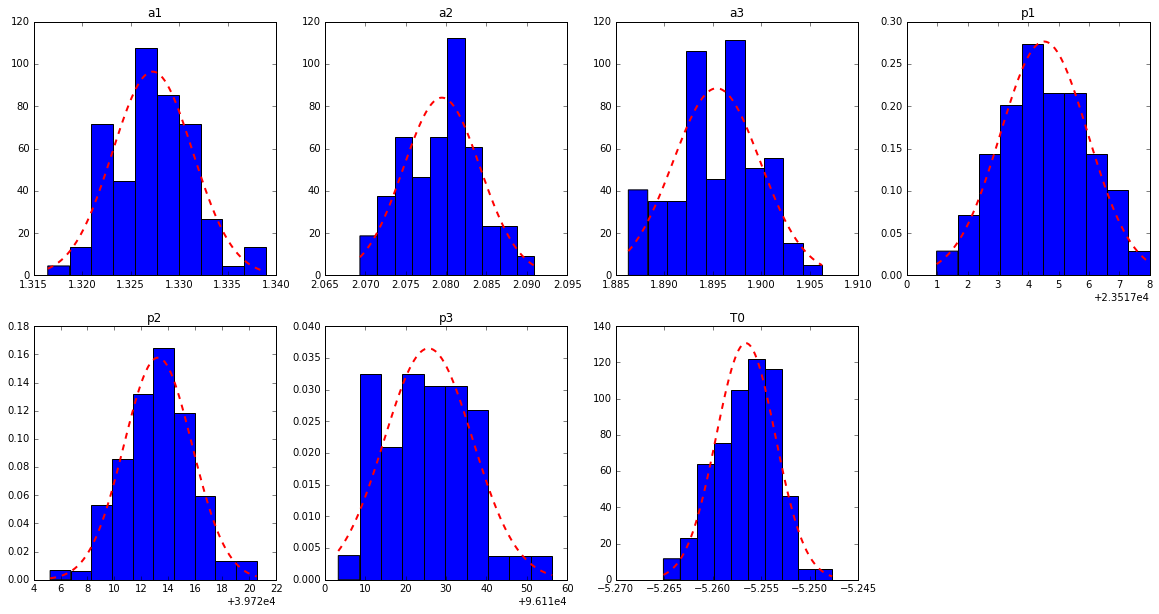

In [103]:
def param_dispersion(param,labell):
    avg = np.mean(param[:-1])
    var = np.var(param[:-1])
    pdf_x = np.linspace(np.min(param[:-1]),np.max(param[:-1]),100)
    pdf_y = 1.0/np.sqrt(2*np.pi*var)*np.exp(-0.5*(pdf_x-avg)**2/var)
    label = str(param)
    plt.hist(param[:-1],normed=True)
    plt.plot(pdf_x,pdf_y,'r--',lw=2,label='Gaussian Fit')
    plt.title(labell)
plt.subplot(241)
param_dispersion(a1,'a1')
plt.subplot(242)
param_dispersion(a2,'a2')
plt.subplot(243)
param_dispersion(a3,'a3')
plt.subplot(244)
param_dispersion(p1,'p1')
plt.subplot(245)
param_dispersion(p2,'p2')
plt.subplot(246)
param_dispersion(p3,'p3')
plt.subplot(247)
param_dispersion(T0,'T0')
plt.show()


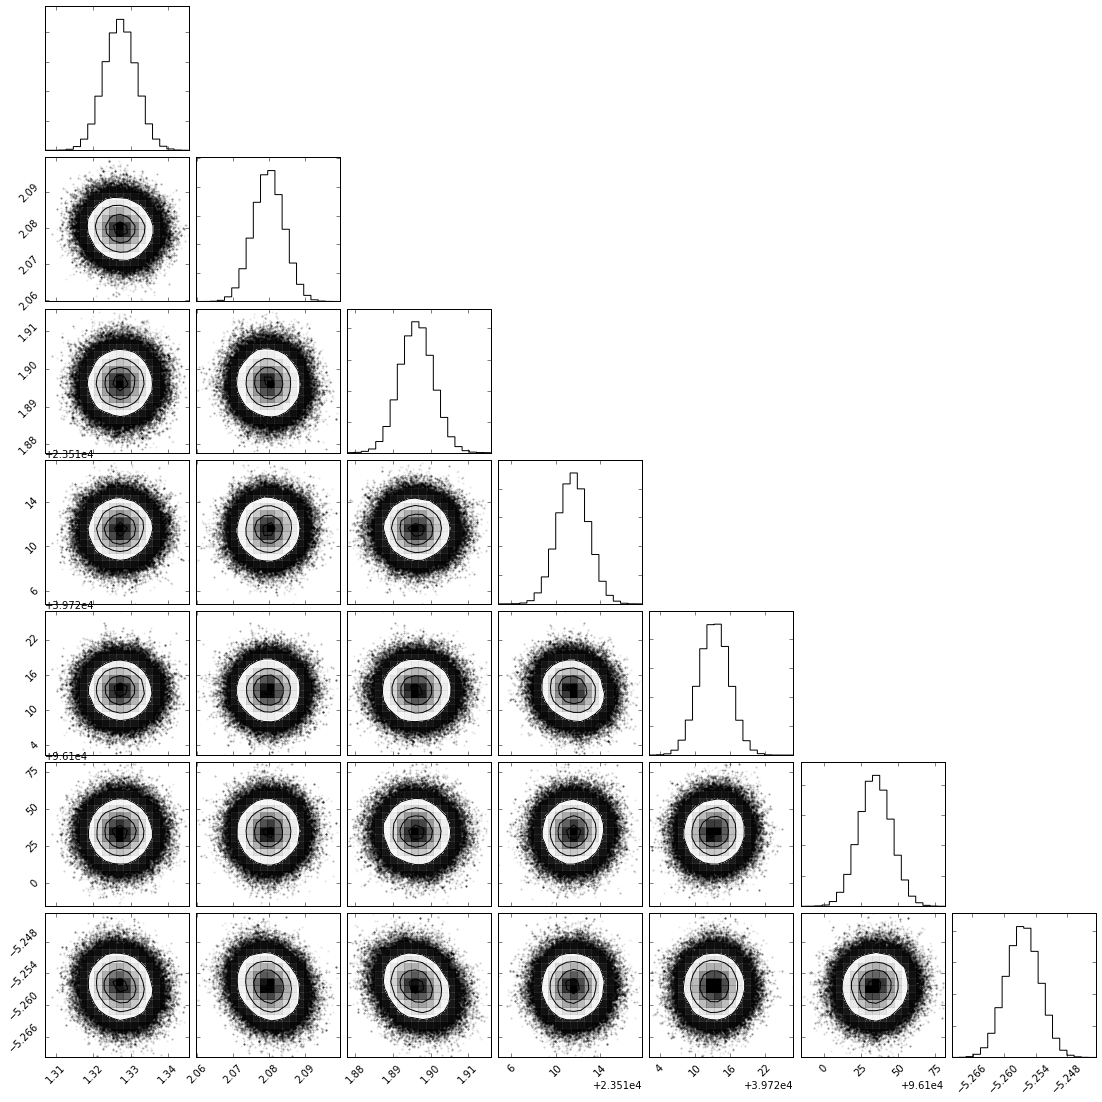

In [104]:
import corner 
fig = corner.corner(samples)